# How to use CNN with time series data

The regular measurements of time series result in a similar grid-like data structure as for the image data we have focused on so far. As a result, we can use CNN architectures for univariate and multivariate time series. In the latter case, we consider different time series as channels, similar to the different color signals.

We will illustrate the time series use case with the univariate asset price forecast example we introduced in the last chapter. Recall that we create rolling monthly stock returns and use the 24 lagged returns alongside one-hot-encoded month information to predict whether the subsequent monthly return is positive or negative.

## Imports & Settings

In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Conv1D, 
                                     Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization)
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

In [35]:
sns.set_style('whitegrid')

## Prepare Data

In [2]:
prices = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
          .adj_close
          .unstack().loc['2007':])
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2896 entries, 2007-01-01 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 70.7 MB


In [3]:
returns = (prices
           .resample('M')
           .last()
           .pct_change()
           .loc['2008': '2017']
           .dropna(axis=1)
           .sort_index(ascending=False))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2017-12-31 to 2008-01-31
Freq: -1M
Columns: 2489 entries, A to ZUMZ
dtypes: float64(2489)
memory usage: 2.3 MB


In [4]:
n = len(returns)
T = 24
tcols = list(range(25))

In [5]:
data = pd.DataFrame()
for i in range(n-T-1):
    df = returns.iloc[i:i+T+1]
    date = df.index.max()
    data = pd.concat([data, 
                      df.reset_index(drop=True).T.assign(date=date).set_index('date')])
data[tcols] = (data[tcols].apply(lambda x: x.clip(lower=x.quantile(.01),
                                                  upper=x.quantile(.99))))
data['label'] = (data[0] > 0).astype(int)
data = data.drop(0, axis=1)
data.sort_index().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236455 entries, 2010-02-28 to 2017-12-31
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   1       236455 non-null  float64
 1   2       236455 non-null  float64
 2   3       236455 non-null  float64
 3   4       236455 non-null  float64
 4   5       236455 non-null  float64
 5   6       236455 non-null  float64
 6   7       236455 non-null  float64
 7   8       236455 non-null  float64
 8   9       236455 non-null  float64
 9   10      236455 non-null  float64
 10  11      236455 non-null  float64
 11  12      236455 non-null  float64
 12  13      236455 non-null  float64
 13  14      236455 non-null  float64
 14  15      236455 non-null  float64
 15  16      236455 non-null  float64
 16  17      236455 non-null  float64
 17  18      236455 non-null  float64
 18  19      236455 non-null  float64
 19  20      236455 non-null  float64
 20  21      236455 non-null  float64

In [6]:
X_train = data[:'2016'].drop('label', axis=1)
y_train = data[:'2016'].label
X_test = data['2017'].drop('label', axis=1)
y_test = data['2017'].label

In [7]:
X_train = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test = X_test.values.reshape(-1, X_train.shape[1], 1)

In [12]:
X_train.shape

(29868, 24, 1)

In [14]:
input_shape = X_train.shape[1:]

## Mutual Information

In [50]:
X = data.drop('label', axis=1)
mi = mutual_info_classif(X=X, y=data.label)
mi = pd.Series(mi, index=X.columns)

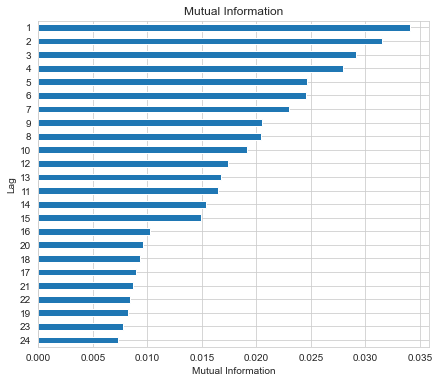

In [58]:
ax = mi.nlargest(25).sort_values().plot.barh(title='Mutual Information', figsize=(7, 6))
ax.set_ylabel('Lag')
ax.set_xlabel('Mutual Information');

## Build ConvNet

### Model Architecture

We design a simple one-layer CNN that uses one-dimensional convolutions combined with max pooling to learn time series patterns:

In [21]:
model = Sequential([
    Conv1D(filters=32, 
           kernel_size=5, 
           activation='relu',
           padding='causal',
           input_shape=input_shape),
    MaxPooling1D(pool_size=2),       
    Flatten(),
    BatchNormalization(),
    Dense(1, activation='sigmoid')])

The model has 673 trainable parameters:

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 24, 32)            192       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 384)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 384)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 385       
Total params: 2,113
Trainable params: 1,345
Non-trainable params: 768
_________________________________________________________________


We compile using our custom auc_roc metric developed in the last chapter:

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')])

We train on returns for the years 2010-16 for 25 epochs (with early stopping) using the default batch size of 32. Each epoch takes around 3s on a single NVIDIA GTX 1080 GPU.

In [27]:
early_stopping = EarlyStopping(monitor='val_AUC',
                               patience=5,
                               restore_best_weights=True,
                               mode='max')

In [28]:
training = model.fit(X_train,
                     y_train,
                     epochs=100,
                     batch_size=32,
                     validation_data=(X_test, y_test),
                     shuffle=True,
                     verbose=1,
                     callbacks=[early_stopping])

Train on 29868 samples, validate on 29868 samples
Epoch 1/100
29868/29868 [==============================] - 4s 125us/sample - loss: 0.6011 - accuracy: 0.6383 - AUC: 0.7066 - val_loss: 0.5889 - val_accuracy: 0.6413 - val_AUC: 0.7157
Epoch 2/100
29868/29868 [==============================] - 3s 107us/sample - loss: 0.5938 - accuracy: 0.6434 - AUC: 0.7141 - val_loss: 0.5923 - val_accuracy: 0.6552 - val_AUC: 0.7317
Epoch 3/100
29868/29868 [==============================] - 3s 108us/sample - loss: 0.5893 - accuracy: 0.6484 - AUC: 0.7202 - val_loss: 0.5828 - val_accuracy: 0.6541 - val_AUC: 0.7217
Epoch 4/100
29868/29868 [==============================] - 3s 109us/sample - loss: 0.5861 - accuracy: 0.6501 - AUC: 0.7225 - val_loss: 0.5895 - val_accuracy: 0.6563 - val_AUC: 0.7235
Epoch 5/100
29868/29868 [==============================] - 3s 107us/sample - loss: 0.5834 - accuracy: 0.6553 - AUC: 0.7257 - val_loss: 0.5717 - val_accuracy: 0.6575 - val_AUC: 0.7361
Epoch 6/100
29868/29868 [==========

In [30]:
accuracy, auc = model.evaluate(X_test, y_test, verbose=0)[1:]
print(f'Accuracy: {accuracy:.2%} | AUC: {auc:.2%}')

Accuracy: 67.45% | AUC: 75.14%


For 2017 returns, we find a test accuracy of 58.28% and test AUC of 0.5701. The network is still underfitting at this point because both training and validation AUC are still improving after 20 epochs, suggesting that longer training and potentially a higher-capacity network would improve results. You should try!

In [37]:
metrics = pd.DataFrame(training.history)

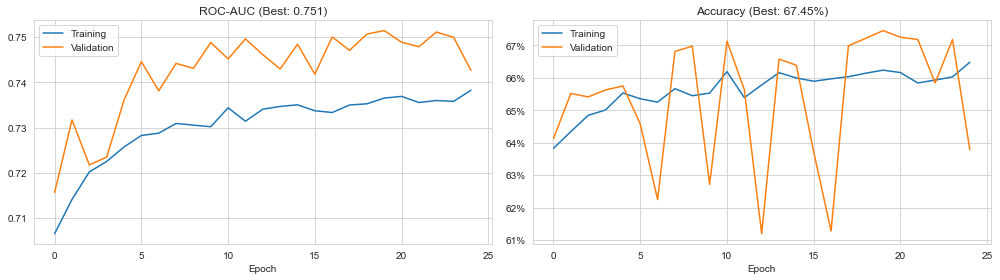

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
metrics[['AUC', 'val_AUC']].plot(title=f'ROC-AUC (Best: {metrics.val_AUC.max():.3f})', ax=axes[0])
metrics[['accuracy', 'val_accuracy']].plot(title=f'Accuracy (Best: {metrics.val_accuracy.max():.2%})', ax=axes[1])
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
for ax in axes:
    ax.legend(['Training', 'Validation'])
    ax.set_xlabel('Epoch')

fig.tight_layout()
fig.savefig('figures/cnn_1D', dpi=300);